<a href="https://colab.research.google.com/github/litvinenkonikita/Physics_based_ML/blob/main/Pipe_analytical_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

It is supposed that the Newtonian fluid flows through a cylindrical pipe with radius $R$. The flow is steady, the Reynolds number is smaller than the critical one $Re < Re^* {\approx} 1100...1400$ and the pipe length is greater than the critical one $L_3 > 0.16RRe$. Then the task is known as Poiseuille flow and it has a simple analytical solution given in cylindrical coordinates $[\rho, \theta, x_3]$:

\begin{equation}
    {v_3} = - \frac{1}{4\mu}\frac{\partial p}{\partial x_3}(R^2 - \rho^2),
\end{equation}
where ${\partial p}/{\partial x_3}$ is the pressure drop along the axis of the cylinder.

The flow rate trough the pipe cross section with surface $S_3$ is equal to:

\begin{equation}
    {Q_3} = \iint_{S_3} v_3 \rho\,d\rho\,d\theta =  - \frac{\pi}{8}\frac{\partial p}{\partial x_3}\frac{R^4}{\mu}.
\end{equation}

# Initialization

## Import libraries

In [50]:
# Pytorch modules
import torch

# Plotting
from matplotlib import pyplot as plt
from matplotlib import cm
import numpy as np

# Work with files and images

## Settings

In [56]:
#Geometric parameters
n = 100
L_3 = 1 
R = 0.01 

#Static parameters
dpdx_3 = -1E+2 #pressure drop

#Dynamic parameters
mu = 1E-2
density = 1E+3

#Coordinates
x_1 = torch.linspace(-R, R, n)
x_1, x_2 = torch.meshgrid(x_1, x_1)

x_1, x_2

(tensor([[-0.0100, -0.0100, -0.0100,  ..., -0.0100, -0.0100, -0.0100],
         [-0.0098, -0.0098, -0.0098,  ..., -0.0098, -0.0098, -0.0098],
         [-0.0096, -0.0096, -0.0096,  ..., -0.0096, -0.0096, -0.0096],
         ...,
         [ 0.0096,  0.0096,  0.0096,  ...,  0.0096,  0.0096,  0.0096],
         [ 0.0098,  0.0098,  0.0098,  ...,  0.0098,  0.0098,  0.0098],
         [ 0.0100,  0.0100,  0.0100,  ...,  0.0100,  0.0100,  0.0100]]),
 tensor([[-0.0100, -0.0098, -0.0096,  ...,  0.0096,  0.0098,  0.0100],
         [-0.0100, -0.0098, -0.0096,  ...,  0.0096,  0.0098,  0.0100],
         [-0.0100, -0.0098, -0.0096,  ...,  0.0096,  0.0098,  0.0100],
         ...,
         [-0.0100, -0.0098, -0.0096,  ...,  0.0096,  0.0098,  0.0100],
         [-0.0100, -0.0098, -0.0096,  ...,  0.0096,  0.0098,  0.0100],
         [-0.0100, -0.0098, -0.0096,  ...,  0.0096,  0.0098,  0.0100]]))

# Analytical solution

Velocity distributioin

In [57]:
v_3 = -1/(4*mu)*dpdx_3*(R**2 - x_1**2 - x_2**2)
v_3max = -1/(4*mu)*dpdx_3*(R**2)

v_3, v_3max

(tensor([[-0.2500, -0.2400, -0.2302,  ..., -0.2302, -0.2400, -0.2500],
         [-0.2400, -0.2300, -0.2202,  ..., -0.2202, -0.2300, -0.2400],
         [-0.2302, -0.2202, -0.2104,  ..., -0.2104, -0.2202, -0.2302],
         ...,
         [-0.2302, -0.2202, -0.2104,  ..., -0.2104, -0.2202, -0.2302],
         [-0.2400, -0.2300, -0.2202,  ..., -0.2202, -0.2300, -0.2400],
         [-0.2500, -0.2400, -0.2302,  ..., -0.2302, -0.2400, -0.2500]]), 0.25)

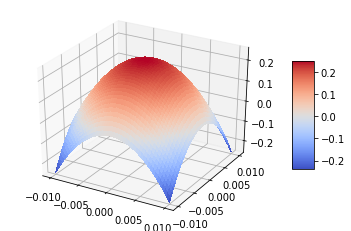

In [59]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(np.array(x_1),np.array(x_2), np.array(v_3), cmap=cm.coolwarm, linewidth=0, antialiased=False)
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

Flow rate

In [47]:
Q_3 = -torch.pi/(8*mu)*dpdx_3*(R**4)
Q_3

3.9269908169872414e-05

Reynolds number and critical length

In [42]:
Re = density*v_3max*2*R/mu
Lcr = 0.16*R*Re
Re, Lcr

(500.0, 0.8)

Since the flow rate distribution $\boldsymbol{V} = [v_1, v_2, v_3]$ is given, the $\boldsymbol\Psi = [\psi_1, \psi_2, \psi_3]$ function can be reconstructed

In [45]:
torch.pi

3.141592653589793